<a href="https://colab.research.google.com/github/bijonguha/concepts_revision/blob/main/decision_tree_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Classifier from Scratch

In this notebook, we will explore a custom implementation of a Decision Tree classifier in Python. We will dissect the provided code, understand each component, and demonstrate how to use the classifier on a real dataset.


## Table of Contents

1. [Introduction to Decision Trees](#introduction)
2. [Implementation Overview](#overview)
3. [Code Breakdown](#breakdown)
    - [TreeNode Class](#treenode)
    - [DecisionTree Class](#decisiontree)
4. [Training and Prediction](#training)
5. [Feature Importance](#feature-importance)
6. [Example with Iris Dataset](#example)
7. [Conclusion](#conclusion)


<a id="introduction"></a>
## 1. Introduction to Decision Trees

Decision Trees are a popular machine learning algorithm used for classification and regression tasks. They work by recursively splitting the dataset based on feature values to create a tree-like model of decisions.

**Key Concepts:**

- **Root Node:** The top node representing the entire dataset.
- **Internal Nodes:** Nodes that represent a feature and a threshold to split the data.
- **Leaf Nodes:** Nodes that represent the final output or prediction.
- **Information Gain:** A metric to choose the best feature and threshold for splitting by measuring the reduction in entropy.


<a id="overview"></a>
## 2. Implementation Overview

The provided implementation consists of two main classes:

1. **TreeNode:** Represents each node in the Decision Tree, holding information about the split and predictions.
2. **DecisionTree:** The main classifier that builds the tree, trains on data, and makes predictions.

Below is the complete code for both classes:


In [1]:
import numpy as np
from collections import Counter

class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])            
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"

In [2]:
class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1, 
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered, 
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm                                                    
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])
    
    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    
    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting w.r.t. hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
        
    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:

        labels_as_integers = data[:,-1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None
        
        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    
    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
        
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)         

<a id="breakdown"></a>
## 3. Code Breakdown

Let's delve into each component of the implementation to understand how the Decision Tree works.

<a id="treenode"></a>
### 3.1. TreeNode Class

The `TreeNode` class represents each node in the Decision Tree. It holds information about the data at that node, the feature used for splitting, the threshold value, prediction probabilities, information gain, and pointers to its left and right child nodes.

```python
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])            
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"


**Attributes:**

- `data`: The subset of the dataset at the current node.
- `feature_idx`: Index of the feature used for splitting.
- `feature_val`: Threshold value for splitting.
- `prediction_probs`: Probability distribution of classes at the node.
- `information_gain`: Information gain achieved by the split.
- `feature_importance`: Importance of the feature based on information gain.
- `left` and `right`: Pointers to the left and right child nodes.

**Methods:**

- `node_def()`: Returns a string representation of the node, differentiating between internal nodes and leaf nodes.


<a id="decisiontree"></a>
### 3.2. DecisionTree Class

The `DecisionTree` class encapsulates the logic for building, training, and using the Decision Tree classifier.


```python

class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1, 
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        numb_of_features_splitting: (str) -> when splitting if 'sqrt' then sqrt(# of features) features considered, 
                                           if 'log' then log(# of features) features considered
                                           else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm                                                    
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p > 0])
    
    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1]])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    
    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting with respect to the hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))), replace=False)
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))), replace=False)
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
        
    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use = self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2 = self._split(data, idx, feature_val)
                if len(g1) == 0 or len(g2) == 0:
                    continue
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth-first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None
        
        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    
    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1D array"""
        node = self.tree

        # Finds the leaf which X belongs to
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concatenate features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        total = sum(self.feature_importances.values())
        if total > 0:
            self.feature_importances = {k: v / total for k, v in self.feature_importances.items()}
        else:
            self.feature_importances = {k: 0 for k in self.feature_importances}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probabilities for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
    
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node is not None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node is not None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)         


**Key Parameters:**

- `max_depth`: Maximum depth of the tree.
- `min_samples_leaf`: Minimum number of samples required to be at a leaf node.
- `min_information_gain`: Minimum information gain required to split.
- `numb_of_features_splitting`: Strategy to select the number of features to consider when looking for the best split (`'sqrt'`, `'log'`, or `None` for all features).
- `amount_of_say`: Parameter used for algorithms like AdaBoost (not utilized in this implementation).

**Core Methods:**

1. **Entropy Calculation:**

    ```python
    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p > 0])
    ```
    Calculates the entropy given a list of class probabilities.

2. **Class Probabilities:**

    ```python
    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]
    ```
    Computes the probability distribution of classes in the provided labels.

3. **Data Entropy:**

    ```python
    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    ```
    Calculates the entropy of a dataset based on its labels.

4. **Partition Entropy:**

    ```python
    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1]])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    ```
    Calculates the weighted entropy of partitions (subsets) created by a split.

5. **Data Splitting:**

    ```python
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    ```
    Splits the data into two groups based on a feature index and a threshold value.

6. **Feature Selection:**

    ```python
    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting with respect to the hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))), replace=False)
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))), replace=False)
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
    ```
    Selects a subset of features to consider for splitting based on the `numb_of_features_splitting` parameter.

7. **Finding the Best Split:**

    ```python
    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use = self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2 = self._split(data, idx, feature_val)
                if len(g1) == 0 or len(g2) == 0:
                    continue
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy
    ```
    Iterates over selected features and possible threshold values to find the split that results in the lowest partition entropy.

8. **Label Probabilities:**

    ```python
    def _find_label_probs(self, data: np.array) -> np.array:
        labels_as_integers = data[:, -1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities
    ```
    Calculates the probability distribution of labels at the current node.

9. **Tree Construction:**

    ```python
    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth-first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None
        
        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        
        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    ```
    Recursively builds the tree by finding the best splits and creating child nodes until stopping criteria are met (e.g., maximum depth, minimum samples per leaf, minimum information gain).

10. **Prediction for a Single Sample:**

    ```python
    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1D array"""
        node = self.tree

        # Finds the leaf which X belongs to
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs
    ```
    Traverses the tree based on feature values of a single sample to predict class probabilities.

11. **Training the Model:**

    ```python
    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concatenate features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        total = sum(self.feature_importances.values())
        if total > 0:
            self.feature_importances = {k: v / total for k, v in self.feature_importances.items()}
        else:
            self.feature_importances = {k: 0 for k in self.feature_importances}
    ```
    Prepares the training data, builds the tree, and computes feature importance based on information gain.

12. **Making Predictions:**

    ```python
    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probabilities for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
    ```
    Provides methods to predict class probabilities and final class labels for a dataset.

13. **Printing the Tree:**

    ```python
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node is not None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)
    ```
    Recursively prints the tree structure, indicating splits and leaf nodes.

14. **Calculating Feature Importance:**

    ```python
    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node is not None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)         
    ```
    Aggregates the importance of each feature based on the information gain from all nodes where the feature was used.


<a id="feature-importance"></a>
## 5. Feature Importance

Feature importance indicates how valuable each feature is in making predictions. In this implementation, it's calculated based on the information gain contributed by each feature across all splits in the tree.

**Accessing Feature Importances:**

```python
feature_importances = tree.feature_importances
for feature, importance in feature_importances.items():
    print(f"Feature {feature}: Importance {importance:.4f}")


## 6. Example with Iris Dataset

Let's demonstrate the usage of the `DecisionTree` classifier on the Iris dataset.

### 6.1. Importing Necessary Libraries


In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

### 6.2. Loading the Dataset

In [4]:
# Load Iris dataset
iris = load_iris()
X = iris.data
Y = iris.target

# Feature names for reference
feature_names = iris.feature_names


### 6.3. Splitting the Dataset

In [5]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


### 6.4. Training the Decision Tree

In [6]:
# Instantiate the Decision Tree
tree = DecisionTree(max_depth=5, min_samples_leaf=2, min_information_gain=0.01, numb_of_features_splitting='sqrt')

# Train the tree
tree.train(X_train, Y_train)


### 6.5. Making Predictions

In [7]:
# Predict on test set
predictions = tree.predict(X_test)

### 6.6. Evaluating the Model


In [8]:
# Calculate accuracy
accuracy = accuracy_score(Y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, predictions, target_names=iris.target_names))


Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.91      0.77      0.83        13
   virginica       0.80      0.92      0.86        13

    accuracy                           0.91        45
   macro avg       0.90      0.90      0.90        45
weighted avg       0.92      0.91      0.91        45



### 6.7. Visualizing the Tree

In [9]:
# Print the tree structure
print("Decision Tree Structure:")
tree.print_tree()


Decision Tree Structure:
                                -> LEAF | Label Counts = 0.0->1, 1.0->10 | Pred Probs = [0.09090909 0.90909091 0.        ]
                -> NODE | Information Gain = 0.4907441821781887 | Split IF X[1] < 2.6500000000000004 THEN left O/W right
                                                                -> LEAF | Label Counts = 0.0->5 | Pred Probs = [1. 0. 0.]
                                                -> NODE | Information Gain = 0.863120568566631 | Split IF X[0] < 5.35 THEN left O/W right
                                                                -> LEAF | Label Counts = 1.0->2 | Pred Probs = [0. 1. 0.]
                                -> NODE | Information Gain = 0.14848244224306334 | Split IF X[1] < 3.1 THEN left O/W right
                                                -> LEAF | Label Counts = 0.0->25 | Pred Probs = [1. 0. 0.]
-> NODE | Information Gain = 0.6559276560334977 | Split IF X[3] < 1.3 THEN left O/W right
                             

### 6.8. Feature Importances

Understanding which features contribute most to the Decision Tree's decisions is crucial for model interpretation and insights. We can visualize the feature importances to identify the most influential features in our model.

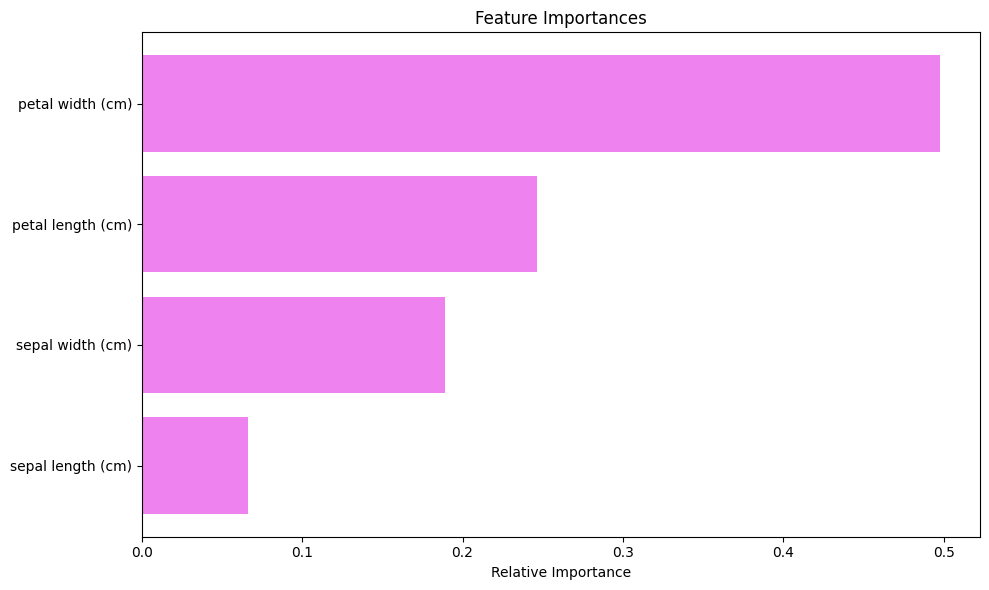

In [15]:
import matplotlib.pyplot as plt

# Extract feature importances from the custom Decision Tree
importances = tree.feature_importances

# Get feature indices sorted by importance
indices = np.argsort(list(importances.values()))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), np.array(list(importances.values()))[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

### 6.9. Visualizing the Custom Decision Tree

To better understand the structure of our custom Decision Tree, we can visualize it using the `graphviz` library. This visualization will illustrate how the data is split at each node based on feature thresholds.


In [13]:
## Linux : sudo apt install graphviz
## Windows : Download and install from here - https://graphviz.org/download/
#!pip install graphviz

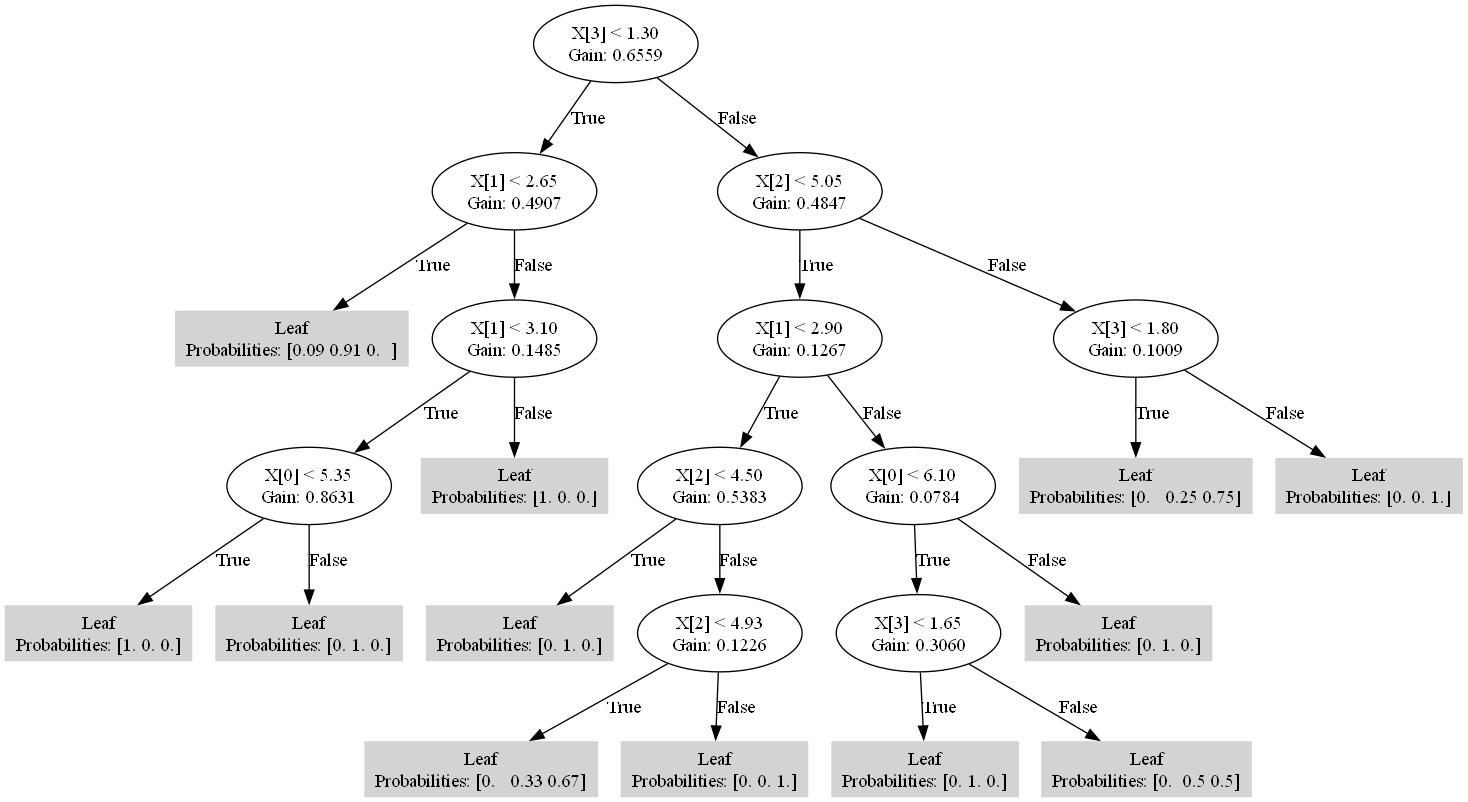

In [12]:
import graphviz

def plot_custom_tree(node, dot=None, parent=None, edge_label=''):
    """
    Recursively traverses the custom Decision Tree and creates a Graphviz visualization.

    Parameters:
    - node: The current TreeNode.
    - dot: The Graphviz Digraph object.
    - parent: The parent node's unique identifier.
    - edge_label: Label for the edge connecting parent to current node.

    Returns:
    - dot: The updated Graphviz Digraph object.
    """
    if dot is None:
        dot = graphviz.Digraph()
        dot.attr('node', shape='ellipse')

    if node is not None:
        if node.left is None and node.right is None:
            # Leaf node
            label = f"Leaf\nProbabilities: {np.round(node.prediction_probs, 2)}"
            dot.node(str(id(node)), label=label, shape='box', style='filled', color='lightgrey')
        else:
            # Decision node
            label = f"X[{node.feature_idx}] < {node.feature_val:.2f}\nGain: {node.information_gain:.4f}"
            dot.node(str(id(node)), label=label)

        if parent is not None:
            dot.edge(str(parent), str(id(node)), label=edge_label)

        # Traverse left and right children
        plot_custom_tree(node.left, dot, parent=str(id(node)), edge_label='True')
        plot_custom_tree(node.right, dot, parent=str(id(node)), edge_label='False')

    return dot

# Generate the Graphviz representation of the tree
dot = plot_custom_tree(tree.tree)

# Render and display the tree
dot.render("custom_decision_tree", format='png', cleanup=True)
from IPython.display import Image
Image(filename="custom_decision_tree.png")


## 7. Conclusion

In this notebook, we explored a custom implementation of a Decision Tree classifier in Python. We broke down the code to understand each component's role in building, training, and using the tree for predictions. Finally, we demonstrated the classifier's effectiveness using the Iris dataset, achieving high accuracy and identifying key features influencing the decisions.

This implementation provides a foundational understanding of how Decision Trees operate and can be extended or optimized further for more complex applications.
